In [1]:
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics
from pylab import*
import seaborn as sns
import numpy as np
from sklearn.model_selection import (GridSearchCV, cross_val_score,
                                                 RandomizedSearchCV,
                                                 cross_validate,
                                                 StratifiedKFold)

## función para la curva ROC

In [20]:
def performance_evaluation_report(model, X_test, y_test, show_plot=False, labels=None, show_pr_curve=False):
    '''
    Function for creating a performance report of a classification model.
    
    Parameters
    ----------
    model : scikit-learn estimator
        A fitted estimator for classification problems.
    X_test : pd.DataFrame
        DataFrame with features matching y_test
    y_test : array/pd.Series
        Target of a classification problem.
    show_plot : bool
        Flag whether to show the plot
    labels : list
        List with the class names.
    show_pr_curve : bool
        Flag whether to also show the PR-curve. For this to take effect, 
        show_plot must be True.
        
    Return
    ------
    stats : pd.Series
        A series with the most important evaluation metrics
    '''

    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    cm = metrics.confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_prob)
    roc_auc = metrics.auc(fpr, tpr)

    precision, recall, thresholds = metrics.precision_recall_curve(
        y_test, y_pred_prob)
    pr_auc = metrics.auc(recall, precision)

    if show_plot:

        if labels is None:
            labels = ['Negative', 'Positive']

        N_SUBPLOTS = 3 if show_pr_curve else 2
        PLOT_WIDTH = 15 if show_pr_curve else 12
        PLOT_HEIGHT = 5 if show_pr_curve else 6

        fig, ax = plt.subplots(
            1, N_SUBPLOTS, figsize=(PLOT_WIDTH, PLOT_HEIGHT))
        fig.suptitle('Performance Evaluation', fontsize=16)

        sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, cmap='BuGn_r', square=True, cbar=False, ax=ax[0],
                    annot_kws={"ha": 'center', "va": 'center'})
        ax[0].set(xlabel='Predicted label',
                  ylabel='Actual label', title='Confusion Matrix')
        ax[0].xaxis.set_ticklabels(labels)
        ax[0].yaxis.set_ticklabels(labels)

        ax[1].plot(fpr, tpr, 'b-', label=f'ROC-AUC = {roc_auc:.2f} \n GINI = {2*roc_auc-1:.2f}')
        ax[1].set(xlabel='False Positive Rate',
                  ylabel='True Positive Rate', title='ROC Curve')
        ax[1].plot(fp/(fp+tn), tp/(tp+fn), 'ro',
                   markersize=8, label='Decision Point')
        ax[1].plot([0, 1], [0, 1], 'r--')
        ax[1].legend(loc='lower right')

        if show_pr_curve:

            ax[2].plot(recall, precision, label=f'PR-AUC = {pr_auc:.2f}')
            ax[2].set(xlabel='Recall', ylabel='Precision',
                      title='Precision-Recall Curve')
            ax[2].legend()

    stats = {'accuracy': metrics.accuracy_score(y_test, y_pred),
             'precision': metrics.precision_score(y_test, y_pred),
             'recall': metrics.recall_score(y_test, y_pred),
             'specificity': (tn / (tn + fp)),
             'f1_score': metrics.f1_score(y_test, y_pred),
             'cohens_kappa': metrics.cohen_kappa_score(y_test, y_pred),
             'roc_auc': roc_auc,
             'pr_auc': pr_auc}

    return stats

## importar datos

In [3]:
#importar los datos
datos_ext='base_ini_externa.txt'
datos_int='base_ini_interna.csv'
datos_pt1='base_ini_parte1.csv'
datos_comp3='base_comportamiento_3.csv'
datos_comp2='base_comportamiento_2.txt'
datos_inicio='bd_inicio_parte1.txt'
datos_inv='base_inversion.txt'

b_comp3=pd.read_csv(datos_comp3)
b_comp2=pd.read_csv(datos_comp2,delimiter=' ')
b_inicio=pd.read_csv(datos_inicio,delimiter=' ')
b_int=pd.read_csv(datos_int)
b_ext=pd.read_csv(datos_ext,delimiter=' ')
b_pt1=pd.read_csv(datos_pt1)
b_inv=pd.read_csv(datos_inv,delimiter=' ')

## Tratamiento y limpieza de datos

In [4]:
#unir las bases de las variables
merge_t = b_inicio.merge( b_int, on="_id_").merge(b_ext, on='_id_').merge(b_pt1, on='_id_').merge(b_inv,on='_id2_') #unimos las bases
merge_t['num_caso']=merge_t['_id_']  
merge_t=merge_t.set_index('num_caso') #agregamos los id como indices
#merge_t=merge_t.dropna()
merge_t=merge_t.sort_values(by=['_id_'])  

#unir las bases de las variables
comportamiento=pd.merge(b_comp3,b_comp2, how='outer', left_index=True, right_index=True)  #unimos las bases de comportamiento
comportamiento=comportamiento.drop(['mes_informacion_y'], axis=1)     #eliminamos las columnas repetidas
comportamiento=comportamiento.rename(columns={"num_caso_x": "_id_",'num_caso_y':'num_caso'})  #renombramos


In [5]:
comp=comportamiento.groupby(['num_caso']) #agrupar el comportamiento por num caso
#hacemos un data frame que contenga el numero de atrasos entre días, si el cociente es 1 significa que no pagó
pr=pd.DataFrame({'comp':comp['comportamiento_j'].sum()/comp['Tiempo_aparicion'].sum()})
pr['_id_']=pr.index #agregamos la columna _id_ para cruzarla con las demas tablas

In [6]:
n=0.05
len(pr.loc[pr['comp']>=n]) #personas que no pagarón o se atrasaron, entre más cerca de 1 es que no paga

2891

In [7]:
pr=pr.sort_values(by=['_id_'])#ordenar por id
pr['_id_']=pr['_id_'].astype(int)

In [8]:
pr['pr_bin']=pr['comp']                   #copiamos la columna
pr.loc[pr['comp']>=n,'pr_bin']=1    # filtramos con 0 o 1 según su cociente de pr['comp'], 0 no paga
pr.loc[pr['comp']<n,'pr_bin']=0     #1 si paga

In [9]:
tab=merge_t.merge(pr,on='_id_', how="left") 
tab=tab.fillna(0.0)

In [10]:
cols=tab.columns

X=tab.loc[:,[cols[1],cols[3],cols[5],cols[7],cols[8],cols[9],cols[10],cols[11],cols[12],cols[13],cols[14], cols[15]]]
y=tab['pr_bin']

## Aplicar el árbol

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,stratify=y)


In [14]:
dt = DecisionTreeClassifier(criterion="gini",splitter='best', min_samples_split=2, min_samples_leaf=1,random_state=52)
dt.fit(X_train,y_train)

DecisionTreeClassifier(random_state=52)

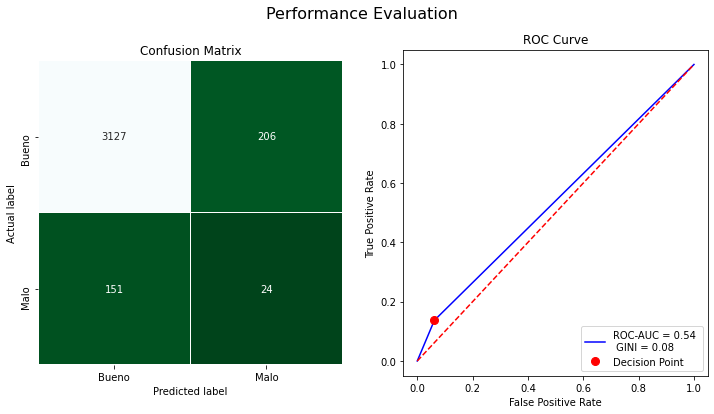

In [21]:
LABELS = ['Bueno', 'Malo']
tree_perf = performance_evaluation_report(dt, X_test,y_test, labels=LABELS,show_plot=True)

In [14]:
from sklearn.model_selection import (GridSearchCV, cross_val_score,
                                                 RandomizedSearchCV,
                                                 cross_validate,
                                                 StratifiedKFold)